# Data Prepocessing

The following steps are taken to preprocess the data.

- **1. Shapefiles**
    - Load shapefiles (precipitation stations, stream gages, dams location and boundaries).
    - Clean, simplify, and reproject shapefiles.
    - Clip and mask data based on region of interest.
    - Create Thiessen Polygons for precipitation stations for taking into account the spatial distibution of rain.
    - Extract relevant features (e.g., drainage area, station location).

- **2. Raster Data**
    - Load raster data (elevation, land cover).
    - Resample and align raster data layers.
    - Clip and mask data based on region of interest.
    - Extract key features (e.g., elevation, impervious surface).
    - Delineate watershed boundaries and extract watershed geomorphological characteristics
    - Normalize raster values.

- **3. Tabular Data**
    - Load time-series data (streamflow, precipitation).
    - Handle missing values and fill gaps.
    - Standardize time formats and indices.
    - Identify and remove outliers.
    - Resample and aggregate data to a uniform time step.
    - Create new features (e.g., moving averages).

- **4. Data Integration**
    - Spatially join shapefiles with raster and tabular data.
    - Merge time-series data based on time and location.
    - Aggregate raster features for each station or gage.

- **5. Selection of Storm Events**

- **6. Clark's parameter optmization**
    - Optmize Clark's parameters for the selected events
    - Spatially join the optmized parameters with shapefile data.

- **5. Machine Learning Preparation**
    - Scale and normalize features.
    - Split dataset into training and testing sets.
    - Encode categorical features.
    - Select most relevant features for training.


In [1]:
# Import modules
from pathlib import Path
import time
import sys
import geopandas as gpd
from shapely.geometry import Point
from plotnine import *
import warnings
from dotenv import load_dotenv
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json

In [2]:
# File paths
project_base_path = Path.cwd().parent.parent

In [3]:
# Add 'src' to system path
sys.path.append(str(project_base_path / 'src'))

# Import modules
from preprocessing.thiessenPolygons import derive_thiessen_polygons
from utils.data_utils import *

# Ignore warnings
warnings.filterwarnings('ignore')

In [4]:
# Load tokens
load_dotenv(project_base_path / '.env')

NOAA_API_TOKEN = os.getenv('NOAA_API_TOKEN')

## 1. Shapefiles

### 1.1 Load shapefiles

In [5]:
# File paths
shapefiles_base_path = project_base_path / 'data'/ 'raw' / 'geo'/ 'shp'

precip_stations_v1_path = shapefiles_base_path / 'precipitation_stations' / 'precip_15.kmz'
precip_stations_v2_path = project_base_path /  'data'/ 'raw' / 'geo'/ 'json' / 'ppt_stations_inventory.json'

us_county_path = shapefiles_base_path / 'us_county' / 'tl_2024_us_county.shp'
us_state_path =  shapefiles_base_path / 'us_state' / 'tl_2024_us_state.shp'

world_utm_zones_path = shapefiles_base_path.parent / 'json' / 'World_UTM_Grid.geojson'

upper_hudson_basin_path = shapefiles_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
upper_hudson_basin_1km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_1km_buffer' / 'upper_hudson_basin_1km_buffer.shp'
upper_hudson_basin_5km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_5km_buffer' / 'upper_hudson_basin_5km_buffer.shp'
upper_hudson_basin_10km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_10km_buffer' / 'upper_hudson_basin_10km_buffer.shp'
upper_hudson_basin_30km_buffer_path = shapefiles_base_path / 'upper_hudson_basin_30km_buffer' / 'upper_hudson_basin_30km_buffer.shp'

In [6]:
# Read shapefiles
try:
    start_time = time.time()

    precip_stations_v1 = gpd.read_file(precip_stations_v1_path)
    precip_stations_v2 = pd.read_json(precip_stations_v2_path)

    us_county = gpd.read_file(us_county_path)
    us_state = gpd.read_file(us_state_path)

    world_utm_zones = gpd.read_file(world_utm_zones_path)

    upper_hudson_basin = gpd.read_file(upper_hudson_basin_path)
    upper_hudson_basin_1km_buffer = gpd.read_file(upper_hudson_basin_1km_buffer_path)
    upper_hudson_basin_5km_buffer = gpd.read_file(upper_hudson_basin_5km_buffer_path)
    upper_hudson_basin_10km_buffer = gpd.read_file(upper_hudson_basin_10km_buffer_path)
    upper_hudson_basin_30km_buffer = gpd.read_file(upper_hudson_basin_30km_buffer_path)

    end_time = time.time()

    print('Shapefiles read successfully. Time elapsed:', round(end_time - start_time, 2), 'seconds')
except Exception as err:
    print('Error reading shapefiles:', err)

Error reading shapefiles: c:\Users\avpalves\Downloads\Pessoal\Unit-Hydrograph-Model\data\raw\geo\shp\precipitation_stations\precip_15.kmz: No such file or directory


In [76]:
# Load map styles
# Load style configuration for maps
map_styles_path = project_base_path / 'config' / 'map_styles.json'
with open(map_styles_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])

### 1.2. Clean and Prepare Datasets
#### 1.2.1. Precipitation Stations

There are two datasets for precipitation locations, V1 with data up to 2013 and V2 with up-to-date data. Those data set covers the entire country and a lot of V2 precipitation stations overlaps V1. They are in `.kmz` and `.json` format V1 and V2 repectevely,  the ID station for V1 is encoded in HTML code, have irrelevant attributes. We will keep both datasets and use them indenpendetly. The following steps will be taken to clean and prepare the dataset:

- **1. Clip the data to have precipitation stations only in area of interest.**
- **2. Decode the HTML code to extract the station ID and elevation.**
- **3. Drop irrelevant attributes.**
- **4. Add begin and end historical data info.**
- **5. Reproject.**
- **6. Evaluate the number of stations within the buffer zones**
- **6. Generate Thiessen Polygons to account for spatial distribution of rain.**
- **7. Save clened files.**


**1.2.1.1. Clip the Data**

For the mask, we will use the study region + 30km buffer to make ensure that none of possible precipitation station is left outside. We will define later which station to use. 


In [77]:
# Convert to geopandas object
nad83_epsg = 'EPSG:4269'
precip_stations_v2['geometry'] = precip_stations_v2.apply(lambda row: Point(row['Lon'], row['Lat']), axis=1)
precip_stations_v2 = gpd.GeoDataFrame(data=precip_stations_v2, crs=nad83_epsg)

# Clip the data
precip_stations_v1_clipped = gpd.clip(precip_stations_v1.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)
precip_stations_v2_clipped = gpd.clip(precip_stations_v2.to_crs(upper_hudson_basin_30km_buffer.crs), upper_hudson_basin_30km_buffer)

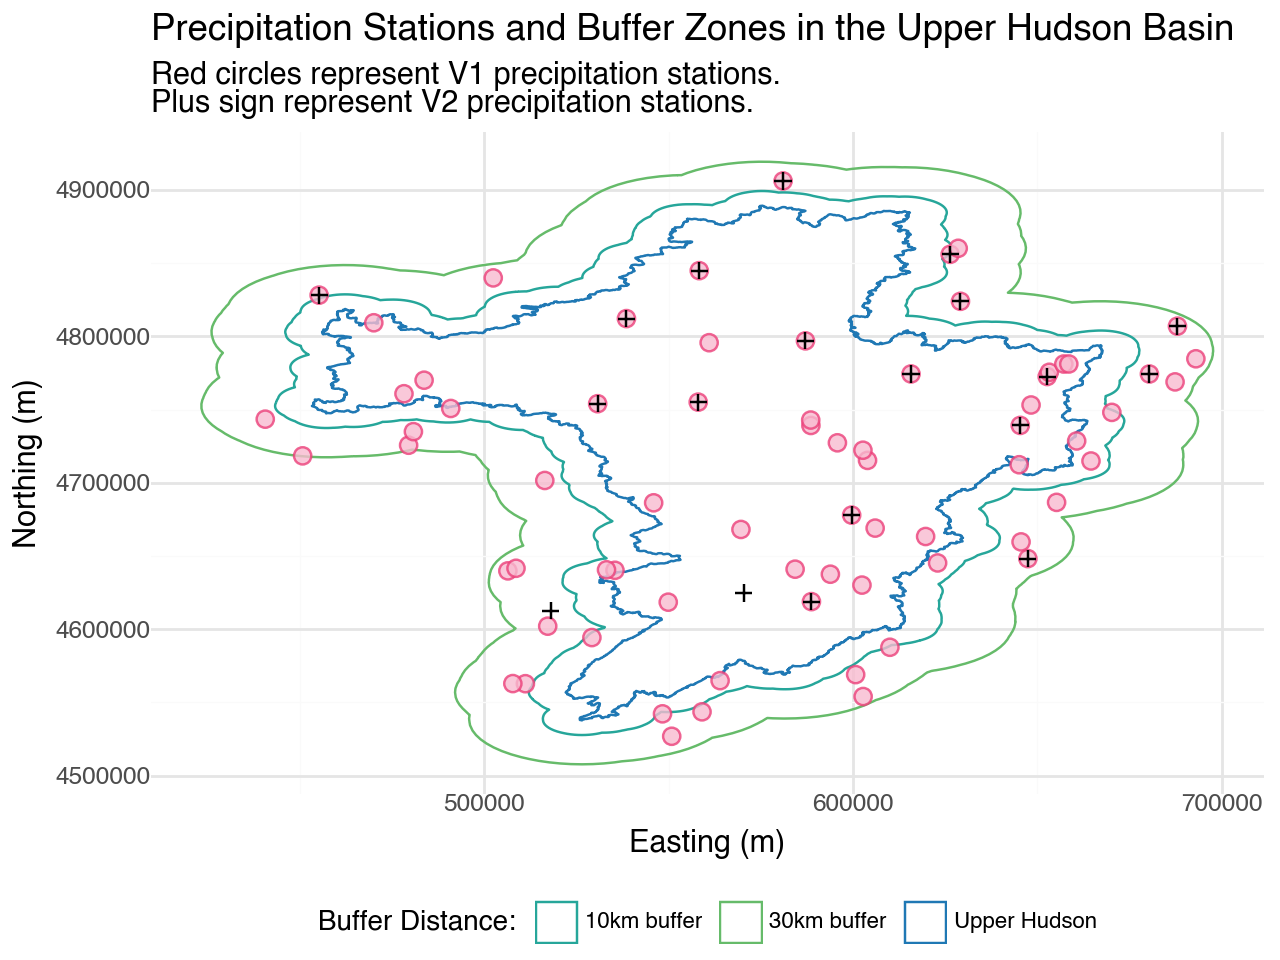

In [96]:
geom_merged = pd.concat(
    [
        upper_hudson_basin.to_crs(precip_stations_v1_clipped.crs)[['geometry']].assign(LAYER='Upper Hudson'),
        upper_hudson_basin_10km_buffer[['geometry']].assign(LAYER='10km buffer'),
        upper_hudson_basin_30km_buffer[['geometry']].assign(LAYER='30km buffer')
    ]
)

precip_station_map = (
    ggplot(geom_merged)
    + geom_map(
        mapping=aes(geometry='geometry', color = 'LAYER'),
        fill = None
    )
    + geom_map(
        data=precip_stations_v1_clipped,
        mapping=aes(geometry='geometry'),
        color=map_style.get('precipitation_station_v1').get('color'),
        fill = map_style.get('precipitation_station_v1').get('fill'),
        shape = map_style.get('precipitation_station_v1').get('shape'),
        size = 3,
        alpha = 0.8
    )
    + geom_map(
        data = precip_stations_v2_clipped[['geometry']],
        mapping=aes(gemetry='geometry'),
        color=map_style.get('precipitation_station_v2').get('color'),
        shape = map_style.get('precipitation_station_v2').get('shape'),
        size = 3,
        alpha = 1
    )
    + labs(title='Precipitation Stations and Buffer Zones in the Upper Hudson Basin',
           subtitle= 'Red circles represent V1 precipitation stations.\nPlus sign represent V2 precipitation stations.',
           x = "Easting (m)", y = "Northing (m)")

    # Manually define colors
    + scale_color_manual(
        name='Buffer Distance:',
        values={
            'Upper Hudson': map_style.get('watershed_boundary').get('color'),
            '10km buffer': map_style.get('watershed_boundary_buffer_10km').get('color'),
            '30km buffer': map_style.get('watershed_boundary_buffer_30km').get('color')
            }
    )
    + coord_cartesian()
    + theme_minimal()
    + theme(
        legend_title=element_text(size=10),
        legend_text=element_text(size=8),
        legend_position='bottom'
    )
)
precip_station_map.show()


In [78]:
# Number of precipitation stations
print('For the study region:')
print(f'There are {precip_stations_v1_clipped.shape[0]} V1 precipitation stations.')
print(f'There are {precip_stations_v2_clipped.shape[0]} V2 precipitation stations.')


For the study region:
There are 70 V1 precipitation stations.
There are 19 V2 precipitation stations.


**1.2.1.2. Decode HTML**

The station ID and elevation attributes, which we want to keep, are encoded in HTML tags. We will extract those attributes and add it to a new column called `precip_station_id`  and `precip_station_elev` respectively. Precipitation elevation is in meters. Below is an example of precipitation station description encoded as html:`

In [79]:
print(precip_stations_v1_clipped['description'].iloc[0])


    
    <table>
    <tr><td>ID: COOP:280907</td></tr>
    <tr><td>COUNTRY: United States</td></tr>
    <tr><td>LATITUDE: 40.89174</td></tr>
    <tr><td>LONGITUDE: -74.39635</td></tr>
    <tr><td>ELEVATION: 85.3 m.</td></tr>
    <tr><td></td></tr>
    </table>
    <table>
    <tr><td><form action="https://www.ncdc.noaa.gov/cdo-web/mapReview" method="post">
        <input type="hidden" name="_dataSet" value="PRECIP_15"/>
        <input type="hidden" name="_stationId" value="COOP:280907"/>
        <input type="submit" value="Access Station Data"/>
    </form></td></tr>
    </table> 
  


In [80]:
# Define function to extract precipitation station id and elevation attributes
def decode_precipt_station_html(html):
    soup = BeautifulSoup(html, 'html.parser')
    id = soup.find('td').text.split(': ')[1].strip()
    elevation = soup.find_all('td')[4].text.split(': ')[1]
    elevation_float = float(elevation.split()[0])

    return pd.Series([id, elevation_float])

# Extract attributes
try:
    precip_stations_v1_clipped[['precip_station_id', 'precip_station_elev']] = precip_stations_v1_clipped['description'].apply(decode_precipt_station_html)
    print('Attribute successfully extracted.')
except Exception as err:
    print(f'Failed to extract attibutes: {err}')

Attribute successfully extracted.


**1.2.1.3. Drop irrelevant attributes**

Below is shows all of the attributes in the V1 precipitation station layer. The relevant attributes are: `Name`, `geometry`, `precip_station_id` and `precip_station_elev`. `begin` and `end` are relavant but they are empty and we will not keep it.

In [81]:
precip_stations_v1_clipped.head()

,id,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,icon,geometry,precip_station_id,precip_station_elev
30,31,"BOONTON 1 SE, NJ US",\n \n <table>\n <tr><td>ID: COOP:2809...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (550850.97 4526914.624 0),COOP:280907,85.3
1,2,"CHARLOTTEBURG RESERVOIR, NJ US",\n \n <table>\n <tr><td>ID: COOP:2815...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (548355.898 4542242.25 0),COOP:281582,237.1
2,3,"WANAQUE RAYMOND DAM, NJ US",\n \n <table>\n <tr><td>ID: COOP:2891...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (559071.261 4543608.511 0),COOP:289187,71.9
225,226,"PLEASANTVILLE, NY US",\n \n <table>\n <tr><td>ID: COOP:3066...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (602750.905 4554064.92 0),COOP:306674,97.5
438,439,"DINGMANS FERRY, PA US",\n \n <table>\n <tr><td>ID: COOP:3621...,NaT,NaT,NaT,None,-1,0,-1,NaN,None,POINT Z (511176.454 4562818.525 0),COOP:362160,131.1


In [82]:
# Remove irrelevant attributes
keep_attributes = ['Name', 'geometry', 'precip_station_id', 'precip_station_elev']
precip_stations_v1_clipped = precip_stations_v1_clipped[keep_attributes]
precip_stations_v1_clipped.head()

,Name,geometry,precip_station_id,precip_station_elev
30,"BOONTON 1 SE, NJ US",POINT Z (550850.97 4526914.624 0),COOP:280907,85.3
1,"CHARLOTTEBURG RESERVOIR, NJ US",POINT Z (548355.898 4542242.25 0),COOP:281582,237.1
2,"WANAQUE RAYMOND DAM, NJ US",POINT Z (559071.261 4543608.511 0),COOP:289187,71.9
225,"PLEASANTVILLE, NY US",POINT Z (602750.905 4554064.92 0),COOP:306674,97.5
438,"DINGMANS FERRY, PA US",POINT Z (511176.454 4562818.525 0),COOP:362160,131.1


**V2 Precipitation Stations**

For **V2 precipitation stations** the follwoing attributes are relevant:  `StnID`,`Lat`,`Lon`,`Elev`,`Name`, `Sample_Interval (min)`,`UTC_Offset`,`POR_Date_Range`,`PCT_Last_Half_Good`, `geometry`. For a detailed explanation about the attributes [refere to the docs](../../docs/other/readme.15min.txt).

In [83]:
keep_attributes = ['StnID','Lat','Lon','Elev','Name', 'Sample_Interval (min)','UTC_Offset','POR_Date_Range','PCT_Last_Half_Good', 'geometry']
precip_stations_v2_clipped = precip_stations_v2_clipped[keep_attributes]
precip_stations_v2_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 19 entries, 1161 to 1157
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   StnID                  19 non-null     object  
 1   Lat                    19 non-null     float64 
 2   Lon                    19 non-null     float64 
 3   Elev                   19 non-null     float64 
 4   Name                   19 non-null     object  
 5   Sample_Interval (min)  19 non-null     int64   
 6   UTC_Offset             19 non-null     int64   
 7   POR_Date_Range         19 non-null     object  
 8   PCT_Last_Half_Good     19 non-null     object  
 9   geometry               19 non-null     geometry
dtypes: float64(3), geometry(1), int64(2), object(4)
memory usage: 1.6+ KB


**1.2.1.4. Add relevant attributes**

The downloaded precipitation stations location layer does not have `begin` and `end`info on its attributes. This info is important to dowloading ([see this notebook](../data%20download/data_download.ipynb)) the historical precipitation data. We tried to retrieve this info from NOOA API. [Documentation available here](https://www.ncdc.noaa.gov/cdo-web/webservices/v2) however, it returns the same date operational periods for each station. Therefore we will not keep it. Below is the code for downloading V1 station metadata.

**Begin** and **End** dates:

In [103]:
def get_precip_station_operational_dates(station_id, token=NOAA_API_TOKEN):
    """
    Retrieves the operational begin and end dates for a given precipitation station.

    Parameters:
        station_id (str): The ID of the precipitation station.
        token (str): NOAA API token.

    Returns:
        dict: Contains 'begin', 'end', and 'n_requests'.
    """
    base_url = 'https://www.ncei.noaa.gov/cdo-web/api/v2/'
    headers = {"Token": token}
    endpoint = 'datasets'
    parameters = {'stationid': station_id}
    max_retries = 4
    count = 0

    for attempt in range(1, max_retries + 1):
        count += 1
        try:
            response = requests.get(url=base_url + endpoint, headers=headers, params=parameters)
            response.raise_for_status()
            data = response.json()

            # Check if 'results' exists and is not empty
            if 'results' not in data or not data['results']:
                raise ValueError(f"No results found for station ID {station_id}")

            begin = data['results'][0].get('mindate')
            end = data['results'][0].get('maxdate')

            return {'begin': begin, 'end': end, 'n_requests': count}

        except (requests.exceptions.RequestException, ValueError) as err:
            print(f"Attempt {attempt} failed for station ID {station_id}: {err}")
            if attempt == max_retries:
                # Return only 'n_requests' to indicate failure
                return {'n_requests': count}
            time.sleep(1)  # Wait before retrying

    # In case the loop exits without returning (shouldn't happen)
    return {'n_requests': count}


In [48]:
overall_start_time = time.time()
# Add begin and end date to geodataframe 
failed_stations_id = []
request_count = 0
start_time = time.time()

for i, row in precip_stations_clipped.iterrows():
    print(f'Getting operational dates for station {row['precip_station_id']}', end= '\r')
    
    # Retrieving only for NaT values
    if row['begin'] is not pd.NaT or row['end'] is not pd.NaT:
        continue

    current_time = time.time()
    elapsed_time = current_time - start_time

    # Reset the counter and timer every second
    if elapsed_time > 1:
        request_count = 0
        start_time = current_time

    if request_count >= 4:
        time.sleep(1)
        request_count = 0
        start_time = time.time()

    try:
        dates = get_precip_station_operational_dates(station_id=row['precip_station_id'])
        request_count += dates.get('n_requests')

    except Exception as err:
        failed_stations_id.append(row['precip_station_id'])
        print(f"Request for data failed for station ID {row['precip_station_id']}: {err}")
        request_count += dates.get('n_requests')
        continue

    if dates:
        try:
            precip_stations_clipped.at[i, 'begin'] = dates.get('begin')
            precip_stations_clipped.at[i, 'end'] = dates.get('end')
        except Exception as err:
            failed_stations_id.append(row['precip_station_id'])
            print(f"Failed to get dates for station ID {row['precip_station_id']}: {err}")
            continue

overall_start_time_str = f"Elapsed time: {round(time.time()-overall_start_time, 2)} seconds."
if failed_stations_id:
    print(f"Ended getting data. Failed for the following stations: {', '.join(failed_stations_id)}. " + overall_start_time_str)
else:
    print(f"Successfully retrieved all begin and end dates. " + overall_start_time_str)

Attempt 1 failed for station ID COOP:301987: 503 Server Error: Service Unavailable for url: https://www.ncei.noaa.gov/cdo-web/api/v2/datasets?stationid=COOP%3A301987
Successfully retrieved all begin and end dates. Elapsed time: 74.66 seconds.


**1.2.1.5. Reproject**

When working with geospatial data in the Upper Hudson River Basin, selecting an appropriate map projection is essential to ensure the accuracy of spatial attribute calculations, such as area and perimeter. For this study, the **NAD83 datum** has been chosen as it is widely used for regional geospatial analysis within the United States. Specifically, we will utilize the **NAD83 / UTM Zone 18N (EPSG:26918)** projection, which is well-suited for the geographic extent of the Hudson River Basin.

The UTM Zone 18N projection minimizes distortions in distance and area measurements by dividing the Earth into zones optimized for small regions. This makes it ideal for hydrological studies and sub-basin analyses, where precision is critical. The projection's use of meters as the measurement unit simplifies calculations of spatial attributes, ensuring consistency and ease of interpretation.

For larger-scale or cross-basin analyses, equal-area projections such as **Albers Equal Area (EPSG:5070)** or **Lambert Conformal Conic (EPSG:102009)** can be considered. However, for this focused study on sub-basins within the Upper Hudson River region, the selected UTM projection provides the most practical and accurate framework.


In [84]:
# Filter UTM bounds to be within the bounds of the upper hudson basin
upper_hudson_basin_bounds = list(upper_hudson_basin.total_bounds)

utm_bounds = world_utm_zones.bounds

utm_intersecting_bounds = (
    (utm_bounds['minx'] < upper_hudson_basin_bounds[2]) &  # UTM left < Basin right
    (utm_bounds['maxx'] > upper_hudson_basin_bounds[0]) &  # UTM right > Basin left
    (utm_bounds['miny'] < upper_hudson_basin_bounds[3]) &  # UTM bottom < Basin top
    (utm_bounds['maxy'] > upper_hudson_basin_bounds[1])    # UTM top > Basin bottom
)
world_utm_zones_filtered = world_utm_zones[utm_intersecting_bounds]

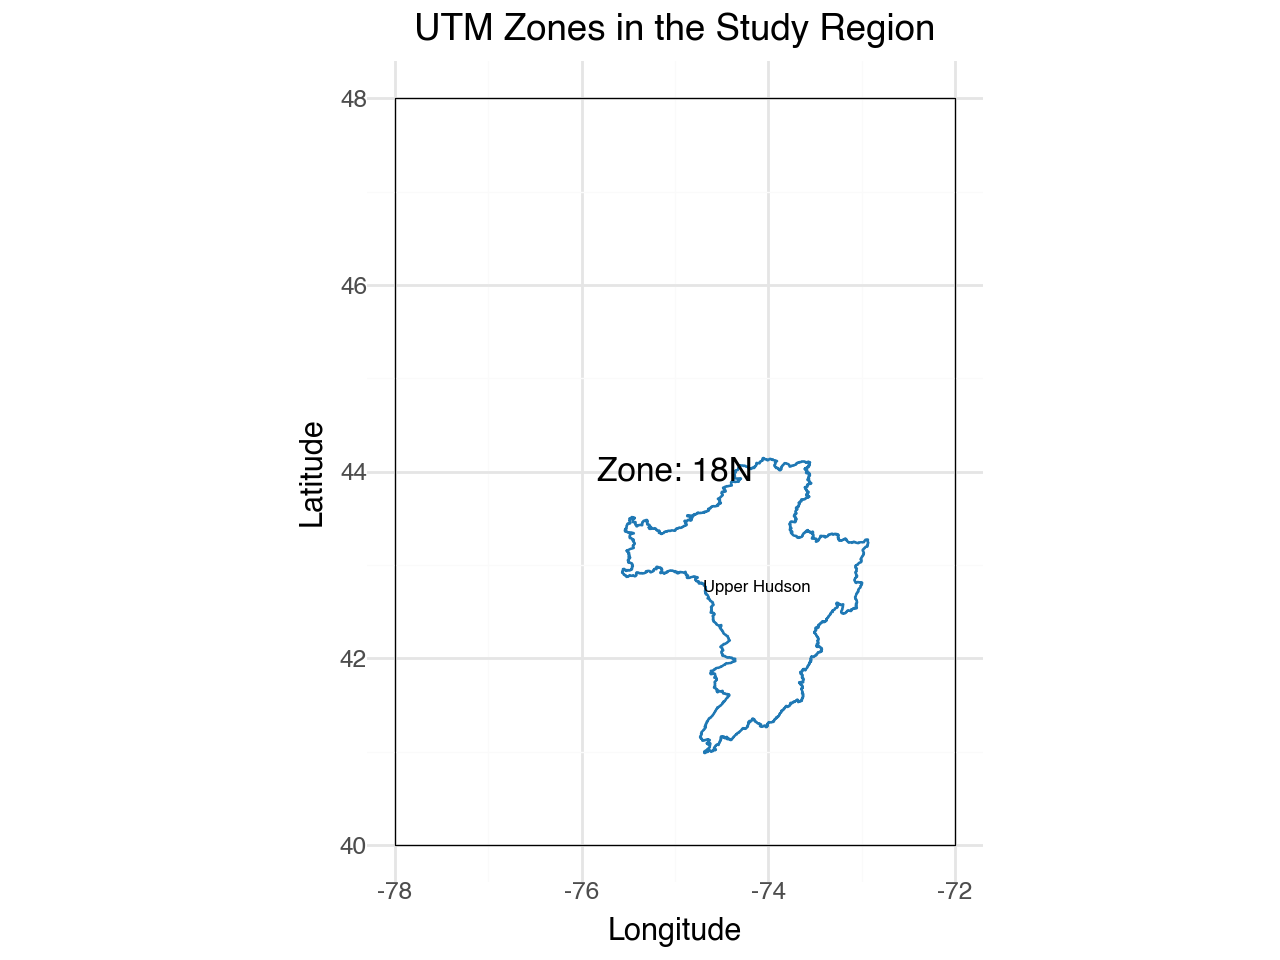

In [105]:
# Define centroid for text legend
world_utm_zones_filtered['lon'] = world_utm_zones_filtered.centroid.x
world_utm_zones_filtered['lat'] = world_utm_zones_filtered.centroid.y

world_utm_zones_filtered['ZONE_str'] = 'Zone: ' + world_utm_zones_filtered['ZONE'].astype(str)+'N'

# Map
utm_zones_map = (
    ggplot(upper_hudson_basin)
        + geom_map(
            mapping=aes(geometry="geometry"),
            inherit_aes=True, 
            color = map_style.get('watershed_boundary').get('color'),
            fill=None
        )
         + geom_text(
            mapping=aes(x="lon", y="lat", label="name"),
            size=6,
            color="black"
        )
        + geom_map(
            mapping=aes(geometry="geometry"),
            data=world_utm_zones_filtered,
            inherit_aes=False,
            color="black",
            size=0.25,
            fill = None
        )
        + geom_text(
            mapping=aes(x="lon", y="lat", label="ZONE_str"),
            size=12,
            color="black",
            data = world_utm_zones_filtered,
            inherit_aes=False
        )
        + coord_fixed()
        + theme_minimal()
        + theme(legend_position="none", panel_grid_major=None, panel_grid_minor=None)
        + labs(title="UTM Zones in the Study Region", x="Longitude", y="Latitude")
    
)
utm_zones_map
                 

In [85]:
target_crs = "EPSG:26918"  # UTM Zone 18N

# Reproject precipitation station and basin layers
precip_stations_v1_clipped = precip_stations_v1_clipped.to_crs(target_crs)
precip_stations_v2_clipped = precip_stations_v2_clipped.to_crs(target_crs)

upper_hudson_basin = upper_hudson_basin.to_crs(target_crs)
upper_hudson_basin_10km_buffer = upper_hudson_basin_10km_buffer.to_crs(target_crs)
upper_hudson_basin_30km_buffer = upper_hudson_basin_30km_buffer.to_crs(target_crs)


**1.2.1.6. Precipitations Stations Within the Buffer Zones**

Depending on the number of sations that fall outside the uppder hudson basin but whithin the limits of 10 or 30km buffer, we will keep stations outside the basin with the goal of increasing our available data.

In [86]:
precip_stations_v1_clipped['within_basin'] = precip_stations_v1_clipped.within(upper_hudson_basin.unary_union)
precip_stations_v1_clipped['within_10kmbuffer'] = precip_stations_v1_clipped.within(upper_hudson_basin_10km_buffer.unary_union)
precip_stations_v1_clipped['within_30kmbuffer'] = precip_stations_v1_clipped.within(upper_hudson_basin_30km_buffer.unary_union)

print(f'For V1 There are {sum(precip_stations_v1_clipped['within_basin'])} stations within boundaries of basin.')
print(f'+ {sum(precip_stations_v1_clipped['within_10kmbuffer'])- sum(precip_stations_v1_clipped['within_basin'])} stations in 10km buffer,')
print(f'+ {sum(precip_stations_v1_clipped['within_30kmbuffer'])- sum(precip_stations_v1_clipped['within_10kmbuffer'])} stations in 30km buffer.\n\n')

precip_stations_v2_clipped['within_basin'] = precip_stations_v2_clipped.within(upper_hudson_basin.unary_union)
precip_stations_v2_clipped['within_10kmbuffer'] = precip_stations_v2_clipped.within(upper_hudson_basin_10km_buffer.unary_union)
precip_stations_v2_clipped['within_30kmbuffer'] = precip_stations_v2_clipped.within(upper_hudson_basin_30km_buffer.unary_union)

print(f'For V2 There are {sum(precip_stations_v2_clipped['within_basin'])} stations within boundaries of basin,')
print(f'+ {sum(precip_stations_v2_clipped['within_10kmbuffer'])- sum(precip_stations_v2_clipped['within_basin'])} stations in 10km buffer.')
print(f'+ {sum(precip_stations_v2_clipped['within_30kmbuffer'])- sum(precip_stations_v2_clipped['within_10kmbuffer'])} stations in 30km buffer.')

For V1 There are 31 stations within boundaries of basin.
+ 10 stations in 10km buffer,
+ 29 stations in 30km buffer.


For V2 There are 11 stations within boundaries of basin,
+ 0 stations in 10km buffer.
+ 8 stations in 30km buffer.


We decide to define the 30km buffer as the area of influence in the study region for precipitation events. 

**1.2.1.6 Thiessen Polygons**

Thiessen polygons, also known as Voronoi polygons or Dirichlet tessellations, are a way to partition a plane into regions based on the distance to points in a specific subset of the plane. For each point, there is a corresponding polygon consisting of all points closer to that point than to any other.

On the context of this study we have several scattered points representing precipitation stations. A Thiessen polygon for a given station encompasses the area that is closer to that station than to any other point in the set. Visually, these polygons are constructed by drawing perpendicular bisectors between each pair of points. The intersections of these bisectors create the boundaries of the polygons.

Thiessen polygons are important tool for defining areas of influence for they provide a clear and unambiguous way to define the area of influence of each point. This is crucial in determining which weather station is most representative of a given location.

However, while simple to understand and implement, Thiessen polygons have limitations. They assume abrupt changes at polygon boundaries and don't account for factors like terrain or other spatial influences. Nontheless, they remain a valuable tool for our model. Since we are working with precipitation stations independetly, we generate thiessen polygon for both precipitations dataset.

In [87]:
try:
    thiessen_polygons_v1_ds = derive_thiessen_polygons(
        gdf_points=precip_stations_v1_clipped,
        clipping_gdf= upper_hudson_basin,
        preserve_attribute='precip_station_id')
    print(f'Thiessen Polygon successfully derived for V1 dataset.')
except Exception as err:
    print(f'Failed to derive Thiessen Polygon for V1 dataset: {err}')

try:
    thiessen_polygons_v2_ds = derive_thiessen_polygons(
        gdf_points=precip_stations_v2_clipped,
        clipping_gdf= upper_hudson_basin,
        preserve_attribute='StnID')
    print(f'Thiessen Polygon successfully derived for V2 dataset.\n')
    
    print(f'{thiessen_polygons_v1_ds.shape[0]} V1 precipitation stations out of {precip_stations_v1_clipped.shape[0]} cover the basin.')
    print(f'{thiessen_polygons_v2_ds.shape[0]} V2 precipitation stations out of {precip_stations_v2_clipped.shape[0]} cover the basin.')

except Exception as err:
    print(f'Failed to derive Thiessen Polygon for V2 dataset: {err}')

Thiessen Polygon successfully derived for V1 dataset.
Thiessen Polygon successfully derived for V2 dataset.

53 V1 precipitation stations out of 70 cover the basin.
18 V2 precipitation stations out of 19 cover the basin.


**Drop unused precipitation stations**

Not all of precipitation stations influence the study region based on Thiessen Polygon. Those stations are dropped from the study. 

In [96]:
precip_stations_v1_filtered = precip_stations_v1_clipped[precip_stations_v1_clipped['precip_station_id'].isin(thiessen_polygons_v1_ds['precip_station_id'])]
precip_stations_v2_filtered = precip_stations_v2_clipped[precip_stations_v2_clipped['StnID'].isin(thiessen_polygons_v2_ds['StnID'])]

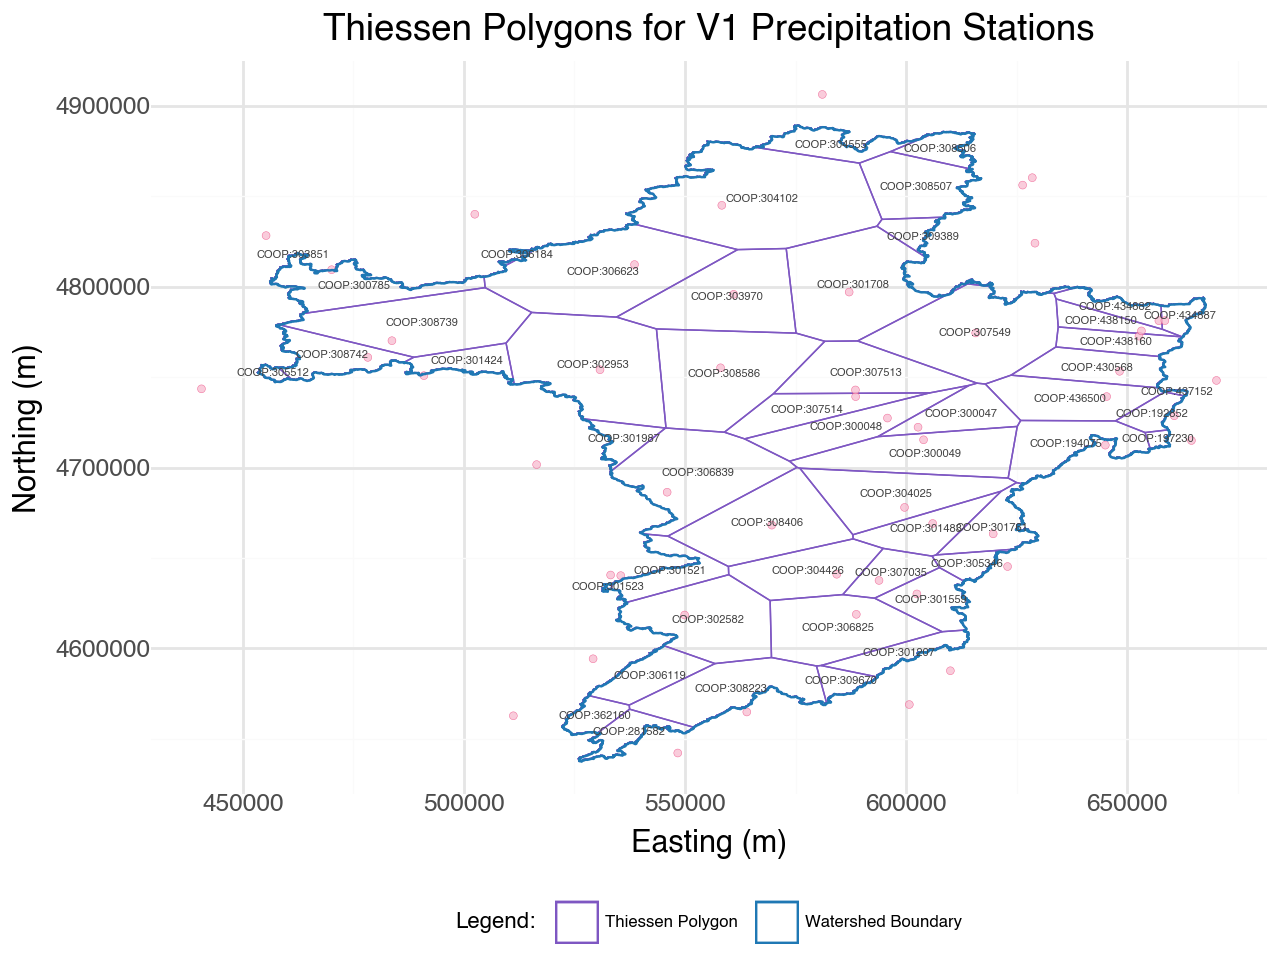

In [97]:
# Compute centroids for placing labels
thiessen_polygons_v1_ds['x'] = thiessen_polygons_v1_ds.centroid.x
thiessen_polygons_v1_ds['y'] = thiessen_polygons_v1_ds.centroid.y

# Add a new column to indicate the type of feature for color mapping
thiessen_polygons_v1_ds['feature_type'] = 'Thiessen Polygon'
upper_hudson_basin['feature_type'] = 'Watershed Boundary'

# Build the plot
thiessen_polygons_v1ds_map = (
    ggplot()
    
    # Thiessen Polygons layer
    + geom_map(
        data=thiessen_polygons_v1_ds,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        size=0.3,
        show_legend=True
    )
    
    # Precipitation Stations layer
    + geom_map(
        data=precip_stations_v1_filtered,
        mapping=aes(geometry='geometry'),
        shape = map_style.get('precipitation_station_v1').get('shape'),
        color = map_style.get('precipitation_station_v1').get('color'),
        fill = map_style.get('precipitation_station_v1').get('fill'),
        alpha=0.75,
        size =1.5, 
        stroke = 0.1
    )
    
    # Upper Hudson Basin layer
    + geom_map(
        data=upper_hudson_basin,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        show_legend=True
    )
    
    # Add labels for precipitation station IDs (using the centroids)
    + geom_text(
        data=thiessen_polygons_v1_ds,
        mapping=aes(x='x', y='y', label='precip_station_id'),
        size=4,
        color=map_style.get('text').get('color')
    )
    
    # Set titles and axes labels
    + labs(title='Thiessen Polygons for V1 Precipitation Stations',
           x="Easting (m)", y="Northing (m)")
    
    + coord_cartesian()
    + theme_minimal()
    
    # Place the legend at the bottom and adjust text sizes
    + theme(
          legend_title=element_text(size=8),
          legend_text=element_text(size=6),
          legend_position='bottom'
      )
    
    # Manually assign colors to each mapped group
    + scale_color_manual(
          name="Legend:",
          values={
              'Thiessen Polygon': map_style.get('thiessen_polygon').get('color'),
              'Watershed Boundary': map_style.get('watershed_boundary').get('color')
          }
      )
)

# Display the plot
thiessen_polygons_v1ds_map.show()


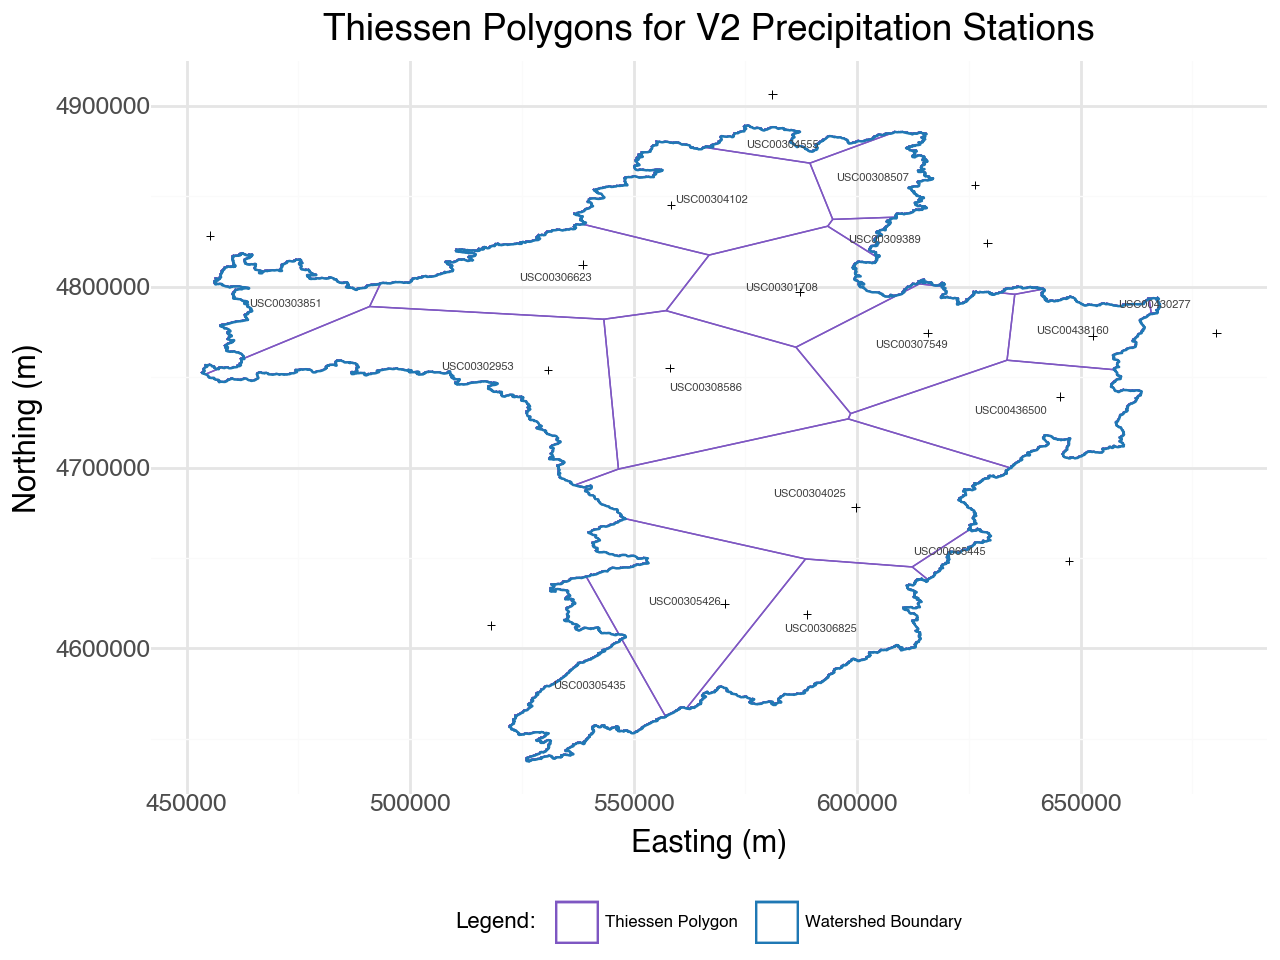

In [98]:
# Compute centroids for placing labels
thiessen_polygons_v2_ds['x'] = thiessen_polygons_v2_ds.centroid.x
thiessen_polygons_v2_ds['y'] = thiessen_polygons_v2_ds.centroid.y

# Add a new column to indicate the type of feature for color mapping
thiessen_polygons_v2_ds['feature_type'] = 'Thiessen Polygon'
upper_hudson_basin['feature_type'] = 'Watershed Boundary'

# Build the plot
thiessen_polygons_v2ds_map = (
    ggplot()
    
    # Thiessen Polygons layer
    + geom_map(
        data=thiessen_polygons_v2_ds,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        size=0.3,
        show_legend=True
    )
    
    # Precipitation Stations layer
    + geom_map(
        data=precip_stations_v2_filtered,
        mapping=aes(geometry='geometry'),
        shape = map_style.get('precipitation_station_v2').get('shape'),
        color = map_style.get('precipitation_station_v2').get('color'),
        fill = map_style.get('precipitation_station_v2').get('fill'),
        size =1.5, 
        stroke = 0.2
    )
    
    # Upper Hudson Basin layer
    + geom_map(
        data=upper_hudson_basin,
        mapping=aes(geometry='geometry', color='feature_type'),
        fill=None,
        show_legend=True
    )
    
    # Add labels for precipitation station IDs (using the centroids)
    + geom_text(
        data=thiessen_polygons_v2_ds,
        mapping=aes(x='x', y='y', label='StnID'),
        size=4,
        color=map_style.get('text').get('color')
    )
    
    # Set titles and axes labels
    + labs(title='Thiessen Polygons for V2 Precipitation Stations',
           x="Easting (m)", y="Northing (m)")
    
    + coord_cartesian()
    + theme_minimal()
    
    # Place the legend at the bottom and adjust text sizes
    + theme(
          legend_title=element_text(size=8),
          legend_text=element_text(size=6),
          legend_position='bottom'
      )
    
    # Manually assign colors to each mapped group
    + scale_color_manual(
          name="Legend:",
          values={
              'Thiessen Polygon': map_style.get('thiessen_polygon').get('color'),
              'Watershed Boundary': map_style.get('watershed_boundary').get('color')
          }
      )
)

# Display the plot
thiessen_polygons_v2ds_map.show()

**1.2.1.6 Save cleaned files**

The following cleaned files will be saved: Precipitation Stations V1, Precipitation Stations V2, Upper Hudson Watershed, Precpitation Stations Metada.

In [ ]:
# Save shapefiles
# First drop columns created along cleaning process that will not be used anymore.
columns_to_trop = ['within_basin','within_10kmbuffer','within_30kmbuffer']
precip_stations_v1_filtered = precip_stations_v1_filtered.drop(labels=columns_to_trop, axis=1)
precip_stations_v2_filtered = precip_stations_v2_filtered.drop(labels=columns_to_trop, axis=1)

# Standard precipitation ID columns name
precip_stations_v1_filtered = precip_stations_v1_filtered.rename(columns={'precip_station_id':'StnID',
                                                                          'precip_station_elev':'elev'})

precip_stations_v1_cleaned_path = project_base_path / 'data' / 'clean' / 'geo' /'shp' / 'precip_stations_v1' /'precip_stations_v1.shp'
precip_stations_v2_cleaned_path = project_base_path / 'data' / 'clean' / 'geo' / 'shp' / 'precip_stations_v2' /'precip_stations_v2.shp'
upper_hudson_basin_cleaned_path = project_base_path / 'data' / 'clean' / 'geo' / 'shp' / 'upper_hudson_basin' /'upper_hudson_basin.shp'
precip_stations_v1_thiessen_poly_path= project_base_path / 'data' / 'clean' / 'geo' / 'shp' / 'precip_stations_v1_thiessen_poly' /'precip_stations_v1_thiessen_poly.shp'
precip_stations_v2_thiessen_poly_path= project_base_path / 'data' / 'clean' / 'geo' / 'shp' / 'precip_stations_v2_thiessen_poly' /'precip_stations_v2_thiessen_poly.shp'


precip_stations_v1_cleaned_path.parent.mkdir(parents=True, exist_ok=True)
precip_stations_v2_cleaned_path.parent.mkdir(parents=True, exist_ok=True)
upper_hudson_basin_cleaned_path.parent.mkdir(parents=True, exist_ok=True)
precip_stations_v1_thiessen_poly_path.parent.mkdir(parents=True, exist_ok=True)
precip_stations_v2_thiessen_poly_path.parent.mkdir(parents=True, exist_ok=True)

try:
    precip_stations_v1_filtered.to_file(precip_stations_v1_cleaned_path)
    precip_stations_v2_filtered.to_file(precip_stations_v2_cleaned_path)
    upper_hudson_basin.to_file(upper_hudson_basin_cleaned_path)
    thiessen_polygons_v1_ds.to_file(precip_stations_v2_thiessen_poly_path)
    thiessen_polygons_v2_ds.to_file(precip_stations_v2_thiessen_poly_path)
    print('Sucessfully saved layers!')
except Exception as err:
    print('Failed to save precipitation file:',err)

Sucessfully saved Precipitation Stations files!


In [ ]:
# Save precipitation stations metadata
precip_stations_v1_codes_path = project_base_path / 'data' / 'clean' / 'json' / 'precip_stations_v1_codes.json'
precip_stations_v2_codes_path = project_base_path / 'data' / 'clean' / 'json' / 'precip_stations_v2_codes.json'


try:
    precip_stations_v1_codes_path.parent.mkdir(parents=True, exist_ok=True)
    precip_stations_v1_filtered[['StnID']].to_json(path_or_buf = precip_stations_v1_codes_path, orient= 'records')
    precip_stations_v2_filtered[['StnID']].to_json(path_or_buf = precip_stations_v2_codes_path, orient= 'records')
    print('Codes sucessfully saved as json file.')
except Exception as err:
    print('Failed to save file:', err)


Codes sucessfully saved as json file.


#### 1.2.1. Stream gage station

Stream gage location are provided by USGS in `.shp` format. For more information on data source, [refere to the data source documentation here](../../docs/markdown/Data%20Sources.md).

The file is cleaned follwoing the steps below:
- **1. Clip.**
- **2. Reproject.**
- **3. Drop irrelevant attributes.**
- **4. Add relevant attributes if necessary.**
- **5. Save clened files.**

**1.2.1.1 Clip**

In [25]:
# Load the data
shapefiles_raw_base_path = project_base_path / 'data'/ 'raw' / 'geo'/ 'shp'
shapefiles_clean_base_path = project_base_path / 'data'/ 'clean' / 'geo'/ 'shp'

streamgage_stations_path = shapefiles_raw_base_path / 'streamgage_stations' / 'realstx.shp'
upper_hudson_basin_path = shapefiles_clean_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
try:
    streamgage_stations = gpd.read_file(streamgage_stations_path)
    upper_hudson_basin = gpd.read_file(upper_hudson_basin_path)
    print('Sucessfully load the data!')
except Exception as err:
    print('Failed to load data:',err)

Sucessfully load the data!


In [26]:
# clip
streamgage_stations_clipped = gpd.clip(gdf = streamgage_stations.to_crs(upper_hudson_basin.crs), mask = upper_hudson_basin)

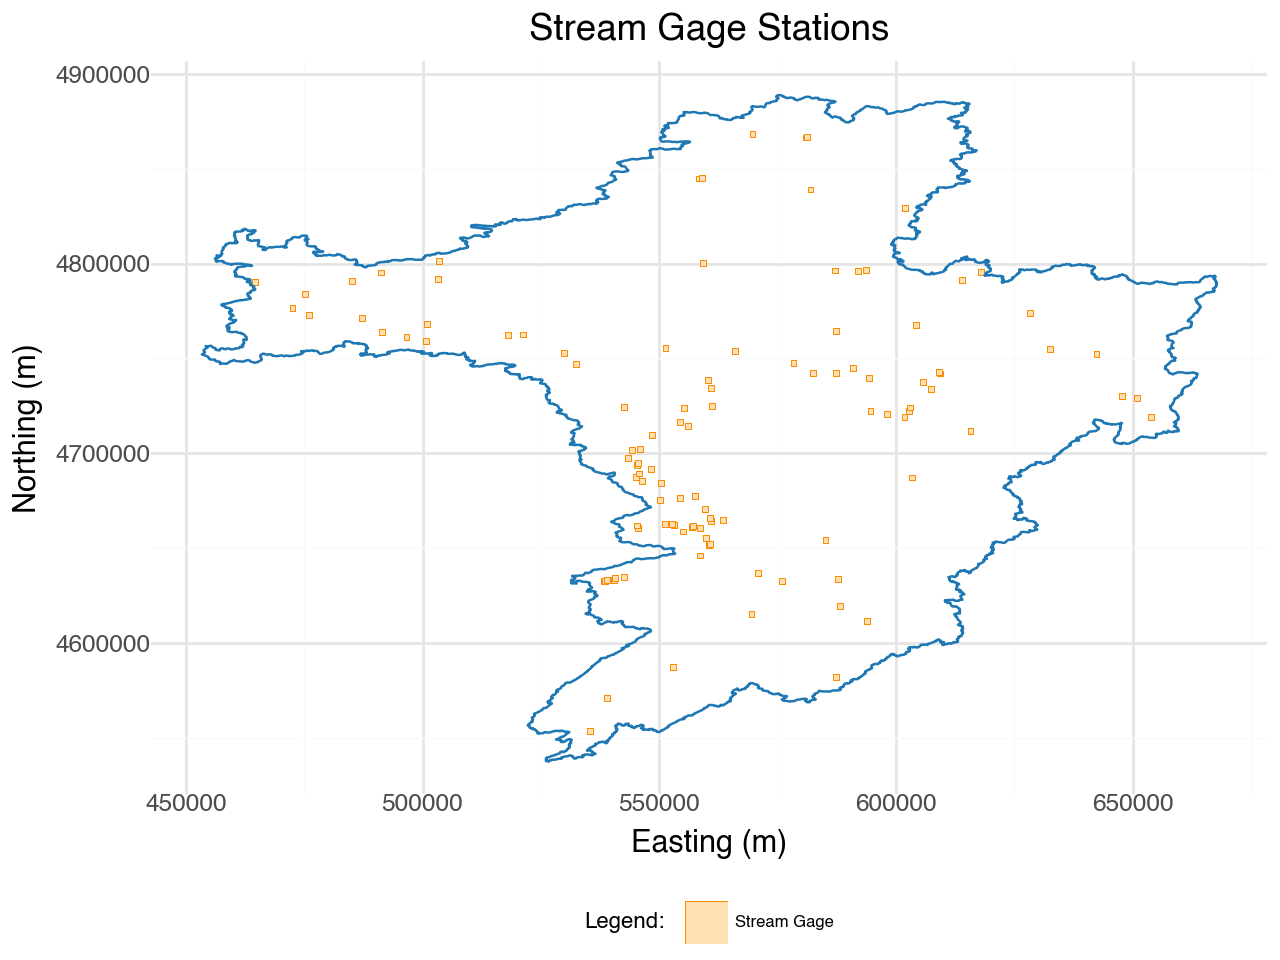

In [20]:
# Map
# Compute position for placing labels
streamgage_stations_clipped['x'] = streamgage_stations_clipped.geometry.x
streamgage_stations_clipped['y'] = streamgage_stations_clipped.geometry.y

# Add a new column to indicate the type of feature for color mapping
streamgage_stations_clipped['feature_type'] = 'Stream Gage'

# Build the plot
streamgage_stations_map = (
    ggplot()
    
    # Stream Gage layer
    + geom_map(
        data=streamgage_stations_clipped,
        mapping=aes(geometry='geometry', color='feature_type', fill = 'feature_type'),
        alpha = 1,
        size=1,
        stroke = 0.2,
        shape = map_style.get('stream_gage').get('shape'),
        show_legend=True
    )
    
    # Upper Hudson Basin layer
    + geom_map(
        data=upper_hudson_basin,
        mapping=aes(geometry='geometry'),
        color = map_style.get('watershed_boundary').get('color'),
        fill=None
    )
    
    # Set titles and axes labels
    + labs(title='Stream Gage Stations',
           x="Easting (m)", y="Northing (m)")
    
    + coord_cartesian()
    + theme_minimal()
    
    # Place the legend at the bottom and adjust text sizes
    + theme(
          legend_title=element_text(size=8),
          legend_text=element_text(size=6),
          legend_position='bottom'
      )
    
    # Manually assign colors to each mapped group
    + scale_color_manual(
          name="Legend:",
          values={
              'Stream Gage': map_style.get('stream_gage').get('color')
          }
      )
    + scale_fill_manual(
        name = 'Legend:',
        values={
            'Stream Gage': map_style.get('stream_gage').get('fill')
        }
    )
)

# Display the plot
streamgage_stations_map.show()

**1.2.1.2 Reproject**

From the previous step, it was found the study region to fall within 18N UTM zone (EPSG 26918), and therefore all geo data is reprojected to EPSG:26918. Because the file was clipped on already projected mask, we expect the CRS to be in the correct projection.

In [27]:
target_crs = 'EPSG:26918'
if streamgage_stations_clipped.crs == target_crs:
    print('Stream gage location already in the correct projection:', target_crs)
else:
    print('File not in the correct CRS. Projecting file...')
    streamgage_stations_clipped = streamgage_stations_clipped.to_crs(target_crs)

Stream gage location already in the correct projection: EPSG:26918


**1.2.1.3 Drop irrelevant attributes**


In [28]:
streamgage_stations_clipped.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 111 entries, 500 to 400
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   STAID       111 non-null    object        
 1   STANAME     111 non-null    object        
 2   ST          111 non-null    object        
 3   HUC         111 non-null    object        
 4   CLASS       111 non-null    int32         
 5   FLOW        111 non-null    float64       
 6   STAGE       111 non-null    float64       
 7   TIME        110 non-null    object        
 8   TIME_UTC    111 non-null    datetime64[ms]
 9   URL         111 non-null    object        
 10  DATUM       111 non-null    object        
 11  COUNT       111 non-null    int32         
 12  PERCENTILE  111 non-null    float64       
 13  FLOODSTAGE  111 non-null    float64       
 14  geometry    111 non-null    geometry      
dtypes: datetime64[ms](1), float64(4), geometry(1), int32(2), object(7)
me

In [29]:
streamgage_stations_clipped.head()

,STAID,STANAME,ST,HUC,CLASS,FLOW,STAGE,TIME,TIME_UTC,URL,DATUM,COUNT,PERCENTILE,FLOODSTAGE,geometry
500,01367715,Wallkill R at Scott Road at Franklin NJ,nj,02020007,0,21.3,1.74,2025-02-02 12:15:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,3,25.00,0.0,POINT (535367.974 4553644.072)
501,01368050,WALLKILL RIVER AT OIL CITY ROAD NEAR UNIONVILL...,ny,02020007,0,0.0,6.61,2025-02-02 12:00:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,5,16.67,0.0,POINT (538992.469 4570814.725)
502,01370520,WALLKILL RIVER AT PHILLIPSBURG NY,ny,02020007,0,0.0,4.13,2025-02-02 12:45:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,5,38.69,0.0,POINT (552970.282 4587618.305)
506,01374019,HUDSON RIVER AT SOUTH DOCK AT WEST POINT NY,ny,02020008,0,0.0,-5.52,2025-02-01 20:15:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,0,0.00,0.0,POINT (587360.071 4582157.632)
505,01372500,WAPPINGER CREEK NEAR WAPPINGERS FALLS NY,ny,02020008,0,0.0,3.34,2025-02-02 12:30:00,2025-02-02,https://waterdata.usgs.gov/monitoring-location...,NAD83,95,29.00,8.0,POINT (593883.052 4611870.574)


For the stream gage location layer, the relevant attributes are: Station ID (STAID) and Station Name (STANAME).

In [30]:
# Drop attributes
keep_attributes = ['STAID', 'STANAME', 'geometry']
streamgage_stations_clipped = streamgage_stations_clipped[keep_attributes]

**1.2.1.4 Save cleaned file**

In [34]:
try:
    streamgage_stations_clipped_path = shapefiles_clean_base_path / 'streamgages' / 'streamgages.shp'
    streamgage_stations_clipped_path.parent.mkdir(parents=True, exist_ok=True)
    streamgage_stations_clipped.to_file(streamgage_stations_clipped_path)
    print('Successfully saved cleaned dam layer!')
except Exception as err:
    print('Failed to save layer:',err)

Successfully saved cleaned dam layer!


#### 1.2.1. Dams locations

Dams location are provided by U.S. Army Corps of Engineering in `.shp` format. For more information on data source, [refere to the data source documentation here](../../docs/markdown/Data%20Sources.md).

The file is cleaned follwoing the steps below:
- **1. Clip**
- **2. Reproject**
- **3. Drop irrelevant attributes**
- **5. Save the cleaned files**

**1.2.1.1 Clip**


In [52]:
# Load the data
shapefiles_raw_base_path = project_base_path / 'data'/ 'raw' / 'geo'/ 'shp'
shapefiles_clean_base_path = project_base_path / 'data'/ 'clean' / 'geo'/ 'shp'

dams_path = shapefiles_raw_base_path / 'dams_location' / 'Dams.gpkg'
upper_hudson_basin_path = shapefiles_clean_base_path / 'upper_hudson_basin' / 'upper_hudson_basin.shp'
try:
    dams = gpd.read_file(dams_path)
    upper_hudson_basin = gpd.read_file(upper_hudson_basin_path)
    print('Sucessfully load the data!')
except Exception as err:
    print('Failed to load data:',err)

Sucessfully load the data!


In [54]:
# clip
dams_clipped = gpd.clip(gdf = dams.to_crs(upper_hudson_basin.crs), mask = upper_hudson_basin)

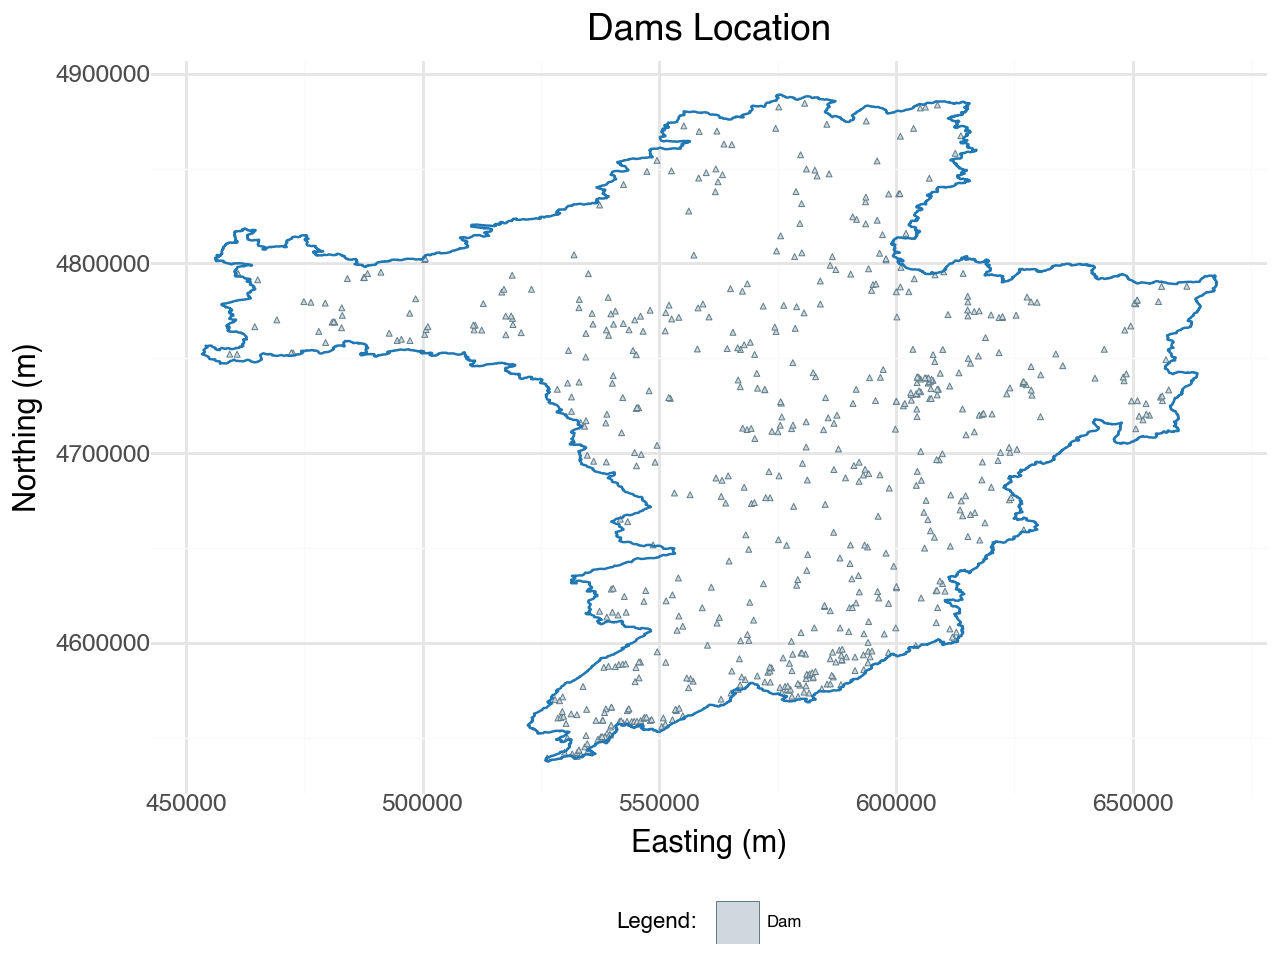

In [57]:
# Map

# Add a new column to indicate the type of feature for color mapping
dams_clipped['feature_type'] = 'Dam'

# Build the plot
dams_map = (
    ggplot()
    
    # Dams layer
    + geom_map(
        data=dams_clipped,
        mapping=aes(geometry='geometry', color='feature_type', fill = 'feature_type'),
        alpha = 1,
        size=1,
        shape = map_style.get('dam').get('shape'),
        stroke = 0.2,
        show_legend=True
    )
    
    # Upper Hudson Basin layer
    + geom_map(
        data=upper_hudson_basin,
        mapping=aes(geometry='geometry'),
        color = map_style.get('watershed_boundary').get('color'),
        fill=None
    )

    # Set titles and axes labels
    + labs(title='Dams Location',
           x="Easting (m)", y="Northing (m)")
    
    + coord_cartesian()
    + theme_minimal()
    
    # Place the legend at the bottom and adjust text sizes
    + theme(
          legend_title=element_text(size=8),
          legend_text=element_text(size=6),
          legend_position='bottom'
      )
    
    # Manually assign colors to each mapped group
    + scale_color_manual(
        name="Legend:",
        values={
            'Dam': map_style.get('dam').get('color')
        }
      )
    + scale_fill_manual(
        name = 'Legend:',
        values={
            'Dam': map_style.get('dam').get('fill')
        }
    )
)

# Display the plot
dams_map.show()

**1.2.1.2 Reproject**

Since the layer was clipped using a projected layer (Upper Hudson Basin Boundary), it is expected for it to be already projected.

In [59]:
target_crs = 'EPSG:26918'
if dams_clipped.crs == target_crs:
    print(f'Layer already in the correct projection: {target_crs}.') 
else:
    dams_clipped = dams_clipped.to_crs(target_crs)
    print(f'Sucessfully projected layer to: {target_crs}.')

Layer already in the correct projection: EPSG:26918.


**1.2.1.3 Drop Attributes**

In [64]:
# Print columns names
dams_clipped.columns

Index(['name', 'otherNames', 'formerNames', 'nidId', 'otherStructureId',
       'federalId', 'ownerNames', 'ownerTypeIds', 'primaryOwnerTypeId',
       'separateStructuresCount', 'isAssociatedStructureId', 'designerNames',
       'nonFederalDamOnFederalId', 'primaryPurposeId', 'purposeIds',
       'sourceAgency', 'stateFedId', 'latitude', 'longitude', 'state',
       'county', 'countyState', 'city', 'distance', 'riverName', 'congDist',
       'stateRegulatedId', 'jurisdictionAuthorityId', 'stateRegulatoryAgency',
       'permittingAuthorityId', 'inspectionAuthorityId',
       'enforcementAuthorityId', 'fedRegulatedId', 'fedOwnerIds',
       'fedFundingIds', 'fedDesignIds', 'fedConstructionIds',
       'fedRegulatoryIds', 'fedInspectionIds', 'fedOperationIds',
       'fedOtherIds', 'secretaryAgricultureBuiltId',
       'nrcsWatershedAuthorizationId', 'primaryDamTypeId', 'damTypeIds',
       'coreTypeIds', 'foundationTypeIds', 'damHeight', 'hydraulicHeight',
       'structuralHeight', 'n

In [65]:
dams_clipped.head()

,name,otherNames,formerNames,nidId,otherStructureId,federalId,ownerNames,ownerTypeIds,primaryOwnerTypeId,separateStructuresCount,...,huc6,huc8,zipcode,nation,stateKey,femaRegion,femaCommunity,aiannh,geometry,feature_type
2954,West Shore Trail Dam,None,None,NJ01018,None,NJ01018,Estate of Bernard A. Handler,Private,Private,0,...,020200,02020007,07871,USA,NJ,2,Byram township,None,POINT (526335.36 4539488.844),Dam
2949,Blue Heron Lake Dam,None,None,NJ00672,None,NJ00672,Division of Fish & Wildlife,State,State,0,...,020200,02020007,07871,USA,NJ,2,Sparta township,None,POINT (532640.416 4540276.448),Dam
12967,Lake Saginaw Dam,None,None,NJ00024,None,NJ00024,Sparta Hills Beach CLub,Private,Private,0,...,020200,02020007,07871,USA,NJ,2,Sparta township,None,POINT (531617.398 4541568.963),Dam
18456,Sunset Lake Dam,None,None,NJ00659,None,NJ00659,Sunset Lakes Homeowner Association,Private,Private,0,...,020200,02020007,07871,USA,NJ,2,Sparta township,None,POINT (532658.084 4542289.552),Dam
35434,Lake Mohawk Dam,None,None,NJ00017,None,NJ00017,Lake Mohawk Country Club,Private,Private,0,...,020200,02020007,07871,USA,NJ,2,Sparta township,None,POINT (529979.911 4542472.391),Dam


We will keep the following attributes: 'name', 'nidId', 'riverName','damHeight', 'damLength', 'volume', 'maxStorage', 'normalStorage', 'surfaceArea', 'drainageArea', 'maxDischarge'.

- **Units of measure:**
    - **Lengths:** Feet (Ft)
    - **Area:** Acre
    - **Storage:** Acre-Ft
    - **Drainage Area:** Square-Miles (Sq Miles)
    



In [66]:
# Drop attributes
keep_attributes = attributes = ['name', 'nidId', 'riverName','damHeight', 'damLength', 'volume', 'maxStorage', 'normalStorage', 'surfaceArea', 'drainageArea','maxDischarge', 'geometry']
dams_clipped = dams_clipped[keep_attributes]

In [68]:
dams_clipped

,name,nidId,riverName,damHeight,damLength,volume,maxStorage,normalStorage,surfaceArea,drainageArea,maxDischarge,geometry
2954,West Shore Trail Dam,NJ01018,Wallkill River,None,None,None,None,None,None,None,None,POINT (526335.36 4539488.844)
2949,Blue Heron Lake Dam,NJ00672,Wallkill River-TR,7,230,None,70,56,15,0.5,None,POINT (532640.416 4540276.448)
12967,Lake Saginaw Dam,NJ00024,Branch of Wallkill River,16,135,None,103,71,15,1,237,POINT (531617.398 4541568.963)
18456,Sunset Lake Dam,NJ00659,Sparta Glen-TR,13,200,None,85,54,11,0.75,675,POINT (532658.084 4542289.552)
35434,Lake Mohawk Dam,NJ00017,Wallkill River,20,580,None,14220,8220,777,4.3,3900,POINT (529979.911 4542472.391)
...,...,...,...,...,...,...,...,...,...,...,...,...
64969,Moss Pond Dam #1,NY13659,MOSS POND BROOK,12,130,None,65,40,10,None,None,POINT (605104.166 4881935.466)
56169,Underwood Dam,NY13662,NEW POND BROOK,18,250,None,72,54,9,None,None,POINT (606186.953 4882384.87)
41778,Henderson Lake Dam,NY01121,INDIAN BROOK,19,283,None,3468,1923,306,17,512,POINT (575225.764 4882452.545)
63047,New Pond Dam,NY01119,NEW POND BROOK,10,75,None,225,225,96,None,None,POINT (608726.534 4883506.418)


**1.2.1.3 Save cleaned file**

In [69]:
try:
    dams_clean_path = shapefiles_clean_base_path / 'dams' / 'dams.shp'
    dams_clean_path.parent.mkdir(parents=True, exist_ok=True)
    dams_clipped.to_file(dams_clean_path)
    print('Successfully saved cleaned dam layer!')
except Exception as err:
    print('Failed to save layer:',err)

Successfully saved cleaned dam layer!


## 1. Tabular data
### 1.2. Historical Precipitation Data

#### 1.2.2 V1 precipitation Data

##### 1.2.2.1 Cleaning

First, we investigate an example of precipitation v2 data, and from there we apply all cleaning steps for all the remaining data. 

In [7]:
# Load data
precip_v2_path = project_base_path / 'data/raw/tabular/precipitation/v1'
file_paths = directories = [name for name in precip_v2_path.iterdir() if name.is_file()]
precip_v2_df = pd.read_csv(file_paths[0])
precip_v2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9443 entries, 0 to 9442
Columns: 491 entries, STATION to DlySumS2
dtypes: float64(3), int64(97), object(391)
memory usage: 35.4+ MB


From the info above, we see that the type of data of v2 precipitation file is wide format. For conducting time series analysis, it is recommended to have data in long format. The first step is to convert to long format.
However, before converting, we drop the following unsused columns:
- **Metadata columns**:
    - **['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION']**: Those columns are present in the shapefile containing the location for precipitation stations and therefore is unecessary.
    - **['STATION']**: is the station id. Since we name the saved file as the station ID, keep this columns would uncessary redundancy. 
    - **['ELEMENT']**: as per documentation, there is currently only one value for `ELEMENT`: **"QPCP"**, which means 15-minute Precipitation total. Therefore there is no use in keeping this columns either.
- **Aggregate columns**
    - **['DlySum', 'DlySumMF', 'DlySumQF', 'DlySumS1', 'DlySumS2']**: those columns are daily sums of precipitation value and quality flags for those sums. Since we will compute it later only if necessary, no need to keep it. 


For information on the data, [access the documentation here](../../docs/other/readme.15min.txt).

**Convert to long format**

In [8]:
# Drop columns
columns_to_trop = ['STATION', 'ELEMENT','LATITUDE', 'LONGITUDE', 'ELEVATION', 'DlySum', 'DlySumMF', 'DlySumQF', 'DlySumS1', 'DlySumS2']
precip_v2_df = precip_v2_df.drop(columns=columns_to_trop)

# Identifying columns to melt
id_vars = ['DATE']
value_vars = [col for col in precip_v2_df.columns if col not in id_vars]

# Melting to long format
precip_v2_df_long = precip_v2_df.melt(id_vars=id_vars,
                                       value_vars=value_vars,
                                       var_name='Time_Attribute',
                                       value_name='Value')

# Add Time to DATE column and extract Attribute from 'Time_Attribute'
precip_v2_df_long['DATE'] = precip_v2_df_long['DATE'].astype(str) + ' ' + precip_v2_df_long['Time_Attribute'].str[:4]
precip_v2_df_long['Attribute'] = precip_v2_df_long['Time_Attribute'].str[4:]

precip_v2_df_long = precip_v2_df_long.drop(columns=['Time_Attribute'])

# Pivoting to separate Value, Measurement Flag, Quality Flag, and Source Flags
df_final = precip_v2_df_long.pivot_table(
    index=['DATE'], 
    columns='Attribute', 
    values='Value', 
    aggfunc='first'
).reset_index()

df_final.columns.name = None 
df_final = df_final.rename({
    'DATE':'date',
    'Val':'height'
}, axis='columns')
glimpse(df_final)

Rows: 906528
Columns: 6
                              Null Count   Dtype         First Values
                              ----------   ------        ------------
date                          0            object        [1984-01-01 0000, 1984-01-01 0015, 1984-01-01 0030, 1984-01-01 0045, 1984-01-01 0100]
MF                            0            object        [g, Z, Z, Z, Z]
QF                            0            object        [ ,  ,  ,  ,  ]
S1                            0            object        [6, 6, 6, 6, 6]
S2                            0            object        [ ,  ,  ,  ,  ]
height                        0            object        [0, 0, 0, 0, 0]


In [53]:
import pandas as pd

def glimpse(df: pd.DataFrame, return_df: bool = False) -> pd.DataFrame | None:
    """
    Provides a quick glimpse of a pandas DataFrame, similar to pd.DataFrame.info().
    Displays the number of rows, columns, and the data types of each column, 
    along with the count of Null entries per column and the first 5 values of each column.

    Parameters:
    -----------
    df : pd.DataFrame
        The pandas DataFrame to be inspected.

    return_df : bool, default False
        If set to True, the function will return a DataFrame containing the first few rows (transposed)
        along with their data types. If False, the function will print out the glimpse to the console.

    Returns:
    --------
    pd.DataFrame or None
        If return_df is True, the function returns a DataFrame containing the first few rows 
        (transposed) of the original DataFrame along with the data types for each column.
        If return_df is False, the function prints the information to the console and returns None.
    """
    # Print the number of rows and columns
    print(f"Rows: {df.shape[0]}")
    print(f"Columns: {df.shape[1]}")

    if return_df:
        # Optionally return the transposed preview with data types
        glimpse_df = (
            df.head()
            .T.assign(dtypes=df.dtypes)
            .loc[:, lambda x: sorted(x.columns, key=lambda col: 0 if col == "dtypes" else 1)]
        )
        return glimpse_df
    else:
        #Find length of each printing column
        dtypes = df.dtypes.astype(str).tolist()
        dtypes_len = max(len(dtype) for dtype in dtypes) + 1

        columns = df.columns.astype(str).tolist()
        columns_len = max(len(col) for col in columns) + 1
        if columns_len > 29:
            columns_len = 29

        # Print details for each column
        col_info = [' '*columns_len + ' Null Count  Dtype' + ' '*(dtypes_len-4) + 'First Values',
                    ' '*columns_len + ' ----------  -----' + ' '*(dtypes_len-4) + '-------------']
        for col in df.columns:
            col_edited = col
            null_count = df[col].isnull().sum()
            dtype = df[col].dtype
            first_values = df[col].head().values
            if len(col)>29:
                col_edited = col_edited[:27] + '...'

            # Convert first values to strings for better formatting
            first_values_str = ', '.join(map(str, first_values))
            col_info.append(f"{col_edited:<{columns_len}} {null_count:<10}  {str(dtype):<{dtypes_len}} [{first_values_str}]")
        
        # Print each column's info
        for col in col_info:
            print(col)
        return None
glimpse(df_final)

Rows: 906528
Columns: 6
        Null Count  Dtype   First Values
        ----------  -----   -------------
date    0           object  [1984-01-01 0000, 1984-01-01 0015, 1984-01-01 0030, 1984-01-01 0045, 1984-01-01 0100]
MF      0           object  [g, Z, Z, Z, Z]
QF      0           object  [ ,  ,  ,  ,  ]
S1      0           object  [6, 6, 6, 6, 6]
S2      0           object  [ ,  ,  ,  ,  ]
height  0           object  [0, 0, 0, 0, 0]


In [ ]:
# Get the columns that are of type object (string type)
string_columns = df_final.select_dtypes(include=['object'])


# Calculate the max length of each string column
max_lengths = string_columns.apply(lambda col: col.str.len().max())

# Show the maximum length for each column
print(max_lengths)

In [35]:
df_final.columns.astype(str).tolist()

['date', 'MF', 'QF', 'S1', 'S2', 'height']